# Redes Neuronales

José Julián Camacho Hernández

Leonardo Guillén Fernández

In [3]:
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import tensorflow as tf
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

## I Parte

In [2]:
# Cargar el set de datos MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Combinar sets de training y test para estratificarlos después
combined_images = np.concatenate((X_train, X_test), axis=0)
combined_labels = np.concatenate((y_train, y_test), axis=0)

# Descartar pixeles en los bordes
combined_images = combined_images[:, 3:-3, 5:-5]

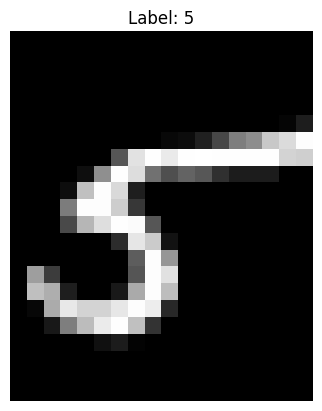

In [5]:
# Seleccionar dato random del dataset
index = np.random.randint(0, len(combined_images))
image = combined_images[index]

# Visualizar la imagen
plt.imshow(image, cmap='gray')
plt.title(f"Label: {combined_labels[index]}")
plt.axis('off')
plt.show()

In [6]:
#=== Feature Engineering ===#

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    combined_images, combined_labels, test_size=0.2, stratify=combined_labels)

# Reshape para pasarlas a 1D
X_train = X_train.reshape(-1, 22*18)
X_test = X_test.reshape(-1, 22*18)

# Normalización de los datos
X_train = X_train / 255.0
X_test = X_test / 255.0

In [57]:
class Perceptron_Multicapa:
    def __init__(self, capas, alpha=0.1):
        self.capas = capas
        self.alpha = alpha
        self.bias = []
        self.pesos = []
        for i in range(0, len(capas) - 1):
            # Inicializar los pesos y bias de cada capa
            peso = np.random.randn(capas[i], capas[i+1])
            self.pesos.append(peso)
            bias = np.random.randn(capas[i+1])
            self.bias.append(bias)

    def activacion(self, x):
        # Función de activación sigmoide
        return 1.0 / (1 + np.exp(-x))

    def activacion_derivada(self, x):
        # Derivada de la función de activación sigmoide
        return x * (1 - x)

    def feedforward(self, X):
        # Calcular la salida de cada capa
        capa_activacion = [X]
        for i in range(0, len(self.capas) - 1):
            x = np.dot(capa_activacion[i], self.pesos[i]) + self.bias[i]
            y = self.activacion(x)
            capa_activacion.append(y)
        return capa_activacion

    def backpropagation(self, X, y, capa_activacion):
        # Calcular el error de la capa de salida
        error = capa_activacion[-1] - y
        delta = error * self.activacion_derivada(capa_activacion[-1])

        # Propagar el error hacia atrás a través de la red neuronal
        for i in reversed(range(0, len(self.capas) - 1)):
            activacion_actual = capa_activacion[i]
            activacion_anterior = capa_activacion[i-1] if i > 0 else X
            d_peso = np.outer(activacion_actual, delta)
            d_bias = delta
            self.pesos[i] -= self.alpha * d_peso
            self.bias[i] -= self.alpha * d_bias
            delta = np.dot(delta, self.pesos[i].T) * self.activacion_derivada(activacion_actual)

    def entrenar(self, X, y, epochs):
        for epoch in range(0, epochs):
            for i in range(0, len(X)):
                # Feedforward
                capa_activacion = self.feedforward(X[i])

                # Backpropagation
                self.backpropagation(X[i], y[i], capa_activacion)

    def predecir(self, X):
        # Obtener la salida de la última capa
        capa_activacion = self.feedforward(X)
        return capa_activacion[-1]
    

In [7]:
def computeMetrics(y_test, y_pred, training_time):
    acc = accuracy_score(y_test, y_pred)                        # Calcular la exactitud
    f1 = f1_score(y_test, y_pred, average='macro')              # Calcular F1 score
    rec = recall_score(y_test, y_pred, average='macro')         # Calcular el recall
    prec = precision_score(y_test, y_pred, average='macro')     # Calcular la precisión
    metrics = {"Accuracy":acc, "Precision":prec, "Recall":rec, "F1 Score":f1, "Tiempo de entrenamiento [s]":training_time}
    df = pd.DataFrame(metrics, index = [0])
    display(df)

In [74]:
# Crear y entrenar el perceptrón multicapa
perceptron = Perceptron_Multicapa(capas=[396, 64, 10], alpha=0.15)

#Tomar tiempo de entrenamiento
start_time = time.time()
perceptron.entrenar(X_train, np.eye(10)[y_train], epochs=5)
end_time = time.time()
time_taken = end_time - start_time

# Hacer predicciones sobre el conjunto de prueba
predicciones = []
for i in range(len(X_test)):
    prediccion = perceptron.predecir(X_test[i])
    prediccion_clase = np.argmax(prediccion)
    predicciones.append(prediccion_clase)

# Calcular la precisión de las predicciones
computeMetrics(y_test, predicciones, time_taken)

,Accuracy,Precision,Recall,F1 Score,Tiempo de entrenamiento [s]
0,0.926929,0.92704,0.925349,0.925434,85.230033


## II Parte

In [18]:
class Perceptron_Multicapa_Multifuncion:
    def __init__(self, capa_entrada, capas, capa_salida, funciones, alpha=0.1):
        self.capas = capas
        self.capa_entrada = capa_entrada
        self.capa_salida = capa_salida
        # Se agregan capas de entrada y de salida
        self.capas.insert(0, self.capa_entrada)
        self.capas.append(self.capa_salida)
        self.funciones = funciones
        self.funciones.insert(0, 'sigmoid')
        self.funciones.append('softmax')
        self.alpha = alpha
        self.bias = []
        self.pesos = []
        # Se elige la función de activación y su derivada por medio de diccionarios
        self.activation_function_dict = {
            'sigmoid': self.activacion_sigmoid,
            'tanh': self.activacion_tanh,
            'relu': self.activacion_relu,
            'softmax': self.activacion_softmax
        }
        self.derivate_function_dict = {
            'sigmoid': self.activacion_derivada_sigmoid,
            'tanh': self.activacion_derivada_tanh,
            'relu': self.activacion_derivada_relu,
            'softmax': self.activacion_derivada_softmax
        }
        for i in range(0, len(capas) - 1):
            # Inicializar los pesos y bias de cada capa
            peso = np.random.randn(capas[i], capas[i+1])
            self.pesos.append(peso)
            bias = np.random.randn(capas[i+1])
            self.bias.append(bias)

    def activacion_softmax(self, x):
        exps = np.exp(x - np.max(x))
        return exps / np.sum(exps)
    
    def activacion_derivada_softmax(self, x):
        s = self.activacion_softmax(x)
        return s * (1 - s)

    def activacion_sigmoid(self, x):
        # Función de activación sigmoide
        return 1.0 / (1 + np.exp(-x))

    def activacion_derivada_sigmoid(self, x):
        # Derivada de la función de activación sigmoide
        return x * (1 - x)

    def activacion_tanh(self, x):
        # Función de activación tanh
        return np.tanh(x)

    def activacion_derivada_tanh(self, x):
        # Derivada de la función de activación tanh
        return (1 - x**2)
    
    def activacion_relu(self, x):
        # Función de activación ReLU
        return np.maximum(0, x)
        
    def activacion_derivada_relu(self, x):
        # Derivada de la función de activación ReLU
        return np.where(x > 0, 1, 0)

    def feedforward(self, X):
        # Calcular la salida de cada capa
        capa_activacion = [X]
        for i in range(0, len(self.capas) - 1):
            #print('capa_activacion[i]', capa_activacion[i].shape)
            #print('self.pesos[i]', self.pesos[i].shape)
            x = np.dot(capa_activacion[i], self.pesos[i]) + self.bias[i]
            y = self.activation_function_dict.get(self.funciones[i], lambda: None)(x)
            capa_activacion.append(y)
        return capa_activacion

    def backpropagation(self, X, y, capa_activacion):
        # Calcular el error de la capa de salida
        error = capa_activacion[-1] - y
        delta = error * self.derivate_function_dict.get(self.funciones[-1], lambda: None)(capa_activacion[-1])
        #delta = error * self.activacion_derivada_relu(capa_activacion[-1])
        # Propagar el error hacia atrás a través de la red neuronal
        for i in reversed(range(0, len(self.capas) - 1)):
            activacion_actual = capa_activacion[i]
            activacion_anterior = capa_activacion[i-1] if i > 0 else X
            d_peso = np.outer(activacion_actual, delta)
            d_bias = delta
            self.pesos[i] -= self.alpha * d_peso
            self.bias[i] -= self.alpha * d_bias
            # Se elige la derivada de la función de activación correspondiente a la capa
            delta = np.dot(delta, self.pesos[i].T) * self.derivate_function_dict.get(self.funciones[i], lambda: None)(activacion_actual)

    def entrenar(self, X, y, epochs):
        for epoch in range(0, epochs):
            for i in range(0, len(X)):
                # Feedforward
                capa_activacion = self.feedforward(X[i])

                # Backpropagation
                self.backpropagation(X[i], y[i], capa_activacion)

    def predecir(self, X):
        # Obtener la salida de la última capa
        capa_activacion = self.feedforward(X)
        return capa_activacion[-1]
    

In [28]:
def MLP_Functions(capa_entrada, capas, capa_salida, funciones, alpha, epochs):

    # Crear y entrenar el perceptrón multicapa
    perceptron = Perceptron_Multicapa_Multifuncion(capa_entrada=capa_entrada, capas=capas, 
        capa_salida=capa_salida, funciones=funciones, alpha=alpha)

    #Tomar tiempo de entrenamiento
    start_time = time.time()
    perceptron.entrenar(X_train, np.eye(10)[y_train], epochs=epochs)
    end_time = time.time()
    time_taken = end_time - start_time

    # Hacer predicciones sobre el conjunto de prueba
    predicciones = []
    for i in range(len(X_test)):
        prediccion = perceptron.predecir(X_test[i])
        prediccion_clase = np.argmax(prediccion)
        predicciones.append(prediccion_clase)

    # Calcular la precisión de las predicciones
    computeMetrics(y_test, predicciones, time_taken)
    print(y_test)
    print(predicciones[:3])

# Llamar función
# Definir red con capas:    396 -  8  -  10  -  30  -   10
# Funciones en las capas:   sgm - sgm - sgm  - tanh - softmax
MLP_Functions(396, [8, 10, 30], 10, ['sigmoid', 'sigmoid', 'tanh'] , 0.125, 10)

,Accuracy,Precision,Recall,F1 Score,Tiempo de entrenamiento [s]
0,0.859929,0.866892,0.858943,0.859621,56.549611


[7 8 4 ... 3 1 3]
[7, 8, 4]


Los mejores resultados se dan para capas ocultas con funciones de activación sigmoid y tanh, y con capa final con softmax.
Con relu no se obtienen buenos resultados.

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Convertir los datos a tensores de PyTorch
X_entrenamiento = torch.Tensor(X_train)
X_prueba = torch.Tensor(X_test)
y_entrenamiento = torch.Tensor(y_train).long()
y_prueba = torch.Tensor(y_test).long()

# Definir la arquitectura de la red neuronal
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(396, 8)    # Capa oculta 1
        self.fc2 = nn.Linear(8, 10)     # Capa oculta 2
        self.fc3 = nn.Linear(10, 30)    # Capa oculta 3
        self.fc4 = nn.Linear(30, 10)    # Capa de salida
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))     # Función de activación ReLU en la capa oculta 1
        x = torch.tanh(self.fc2(x))     # Función de activación tanh en la capa oculta 2
        x = torch.sigmoid(self.fc3(x))  # Función de activación tanh en la capa oculta 3
        x = self.fc4(x)                 # Capa de salida sin función de activación
        return x

# Crear el modelo de la red neuronal
modelo = Net()

# Definir la función de pérdida y el optimizador
criterio = nn.CrossEntropyLoss()
optimizador = optim.Adam(modelo.parameters())

# Entrenar la red neuronal
num_epochs = 1000
#Tomar tiempo de entrenamiento
start_time = time.time()
for epoch in range(num_epochs):
    # Paso de entrenamiento
    optimizador.zero_grad()
    salida = modelo(X_entrenamiento)
    perdida = criterio(salida, y_entrenamiento)
    perdida.backward()
    optimizador.step()
end_time = time.time()
time_taken = end_time - start_time

# Hacer predicciones sobre los datos de prueba
with torch.no_grad():
    salida = modelo(X_prueba)
    _, predicciones = torch.max(salida, 1)

# Calcular la precisión de las predicciones
precision = accuracy_score(y_prueba, predicciones)

computeMetrics(y_prueba, predicciones, time_taken)
print("Precisión:", precision)


,Accuracy,Precision,Recall,F1 Score,Tiempo de entrenamiento [s]
0,0.905857,0.904673,0.904344,0.9044,44.819567


Precisión: 0.9058571428571428


### Comparación de los resultados

Se logra concluir que los mejores resultados se obtienen al realizar el feature engineering y quitar los bordes en color negro de las imágenes, ya que no aportan información relevante al modelo.

Para el perceptrón multicapa con distintas funciones de activación, se obtuvo que los mejores resultados se dan al aplicar la función sigmoid en la mayoría de sus capas y softmax en la última.

En comparación con Sklearn, se logró notar que este alcanza unas mejores métricas en general y necesita considerablemente menos tiempo de entrenamiento, debido a sus optimizaciones matemáticas, ya que hace muchas más epochs en menos tiempo.